In [2]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import tf_integrator as tf_int
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time

In [71]:
sim_time = 1000
sim_res = 0.01
t = np.arange(0.0, sim_time, sim_res)

n_n = 64
p_n = 32
l_n = 32

C_m  = [1.0]*n_n                     

g_K  = [3.6]*p_n+[36]*l_n
g_L  = [0.3]*n_n

E_K  = [-95.0]*p_n + [-95.0]*l_n
E_L  = [-64.0]*p_n + [-50.0]*l_n

g_Na = [7.15]*p_n
g_A  = [1.43]*p_n

E_Na = [50.0]*p_n
E_A  = [-95.0]*p_n

g_Ca = [5.0]*l_n
g_KCa = [0.045]*l_n

E_Ca = [140.0]*l_n
E_KCa = [-95]*l_n

A_Ca = 2*(10**(-4))
Ca0 = 2.4*(10**(-4))
t_Ca = 150

F_b = [0.0]*n_n

In [72]:
def K_prop(V):
    
    V = V-(-50)
    
    T = 23
    
    phi = 3.0**((T-36)/10)
    
    alpha_n = 0.02*(15-V)/(tf.exp((15-V)*0.2) - 1.0)
    beta_n = 0.5*tf.exp((10.0-V)/40.0)
    
    t_n = 1.0/(alpha_n+beta_n)/phi
    n_inf = alpha_n/(alpha_n+beta_n)
    
    return n_inf, t_n


def Na_prop(V):
    
    V = V-(-50)
    
    T = 23
    
    phi = 3.0**((T-36)/10)
    
    alpha_m = 0.32*(13-V)/(tf.exp((13-V)*0.25)-1)
    beta_m = 0.28*(V-40)/(tf.exp((V-40)*0.2)-1)
    
    alpha_h = 0.128*tf.exp((17-V)/18.0)
    beta_h = 4.0/(tf.exp((40-V)*0.2) + 1.0)
    
    t_m = 1.0/(alpha_m+beta_m)/phi
    t_h = 1.0/(alpha_h+beta_h)/phi
    
    m_inf = alpha_m/(alpha_m+beta_m)
    h_inf = alpha_h/(alpha_h+beta_h)
    
    return m_inf, t_m, h_inf, t_h

def A_prop(V):
    
    T = 23
    
    phi = 3.0**((T-23.5)/10)
    
    m_inf = 1/(1+tf.exp(-(V+60.0)/8.5))
    h_inf = 1/(1+tf.exp((V+78.0)/6.0))
    
    tau_m = 0.27/(tf.exp((V + 35.8)/19.7) + tf.exp(-(V + 79.7)/12.7)) + 0.1
    
    t1 = 0.27*1/(tf.exp((V+46.05)/5.0) + tf.exp(-(V+238.4)/37.45)) #/ phi
    t2 = tf.ones(tf.shape(V),dtype=V.dtype)* 5.1 #*(19.0/phi) #*5.1 
    tau_h = tf.where(tf.less(V,-63.0),t1,t2)
    
    return m_inf, tau_m, h_inf, tau_h

def Ca_prop(V):
    
    m_0 = 1/(1+tf.exp(-(V+20.0)/6.5))
    h_0 = 1/(1+tf.exp((V+25.0)/12))
    
    tau_m = 1.5
    tau_h = 0.3*tf.exp((V-40.0)/13.0) + 0.002*tf.exp((60.0-V)/29)
    
    return m_0, tau_m, h_0, tau_h

def KCa_prop(Ca):
    return Ca/(Ca+2), 100/(Ca+2)

In [73]:
def I_K(V, n):
    return g_K  * n**4 * (V - E_K)

def I_L(V):
    return g_L * (V - E_L)

def I_Na(V, m, h):
    return g_Na * m**3 * h * (V - E_Na)

def I_A(V, m, h):
    return g_A * m**4 * h * (V - E_A)

def I_Ca(V, m, h):
    return g_Ca * m**2 * h * (V - E_Ca)

def I_KCa(V, m):
    return g_KCa * m * (V - E_KCa)

def I_inj_t(t):
    return tf.constant(current_input.T,dtype=tf.float64)[tf.to_int32(t*100)]

In [74]:
def nailclipper(X):
    return tf.clip_by_value(X, clip_value_min=0., clip_value_max=1.)

def dXdt(X, t): # X is the state vector
    
    V_p   = X[0   : p_n]
    V_l   = X[p_n : n_n]
    
    n_K   = nailclipper(X[n_n : 2*n_n])
    
    m_Na  = nailclipper(X[2*n_n : 2*n_n + p_n])
    h_Na  = nailclipper(X[2*n_n + p_n : 2*n_n + 2*p_n])

    m_A   = nailclipper(X[2*n_n + 2*p_n : 2*n_n + 3*p_n])
    h_A   = nailclipper(X[2*n_n + 3*p_n : 2*n_n + 4*p_n])
    
    m_Ca  = nailclipper(X[2*n_n + 4*p_n : 2*n_n + 4*p_n + l_n])
    h_Ca  = nailclipper(X[2*n_n + 4*p_n + l_n: 2*n_n + 4*p_n + 2*l_n])
    
    m_KCa = nailclipper(X[2*n_n + 4*p_n + 2*l_n : 2*n_n + 4*p_n + 3*l_n])
    Ca    = X[2*n_n + 4*p_n + 3*l_n: 2*n_n + 4*p_n + 4*l_n]
    
    fire_t = X[-n_n:]
    
    V = X[:n_n]
       
    n0,tn = K_prop(V)
    
    dn_k = - (1.0/tn)*(n_K-n0)
    
    m0,tm,h0,th = Na_prop(V_p)
    
    dm_Na = - (1.0/tm)*(m_Na-m0)
    dh_Na = - (1.0/th)*(h_Na-h0)
    
    m0,tm,h0,th = A_prop(V_p)
    
    dm_A = - (1.0/tm)*(m_A-m0)
    dh_A = - (1.0/th)*(h_A-h0)
    
    m0,tm,h0,th = Ca_prop(V_l)
    
    dm_Ca = - (1.0/tm)*(m_Ca-m0)
    dh_Ca = - (1.0/th)*(h_Ca-h0)
    
    m0,tm = KCa_prop(Ca)
    
    dm_KCa = - (1.0/tm)*(m_KCa-m0)
    
    dCa = - A_Ca*I_Ca(V_l,m_Ca,h_Ca) - (Ca - Ca0)/t_Ca
    
    CmdV_p = - I_Na(V_p, m_Na, h_Na) - I_A(V_p, m_A, h_A)
    CmdV_l = - I_Ca(V_l, m_Ca, h_Ca) - I_KCa(V_l, m_KCa)
    
    CmdV = tf.concat([CmdV_p,CmdV_l],0)
    
    dV = (I_inj_t(t) + CmdV - I_K(V, n_K) - I_L(V)) / C_m
    
    dfdt = tf.zeros(tf.shape(fire_t),dtype=fire_t.dtype)
    
    out = tf.concat([dV,         dn_k,
                     dm_Na,      dh_Na,
                     dm_A,       dh_A,
                     dm_Ca,      dh_Ca,
                     dm_KCa,     
                     dCa,        dfdt   ],0)
    return out

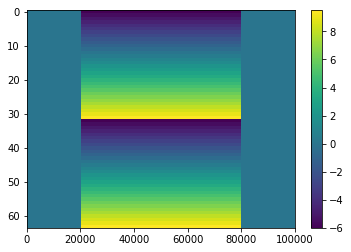

In [77]:
maxc=8

current_input = 0.*np.ones((n_n,t.shape[0]))

y = np.where(t<800,1.0*np.ones(t.shape),0.0*np.ones(t.shape))
y = np.where(t<200,0.0*np.ones(t.shape),y)

for n,i in enumerate(np.arange(-6,10,0.5)):
    current_input[n,:]= i*y
    current_input[32+n,:]= i*y

plt.imshow(current_input,aspect='auto')
plt.colorbar()

In [78]:
state_vector =  [-65]* p_n+[-50]* l_n + [0.0]* (n_n + 4*p_n + 3*l_n) + [2.4*(10**(-4))]*l_n + [-(sim_time+1)]*n_n
state_vector = np.array(state_vector)
init_state = tf.constant(state_vector, dtype=tf.float64)

In [79]:
%%time
ts = time.time()

state = tf_int.odeint(dXdt, init_state, t, n_n, F_b)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    state = sess.run(state)
    sess.close()
    
state=state[:,:-n_n]

CPU times: user 17min 2s, sys: 5min 10s, total: 22min 12s
Wall time: 5min 20s


6.5
7.0
7.5
8.0
8.5
-4.5
-4.0
1.5
2.0
2.5
3.0
3.5
-4.5
-4.0


([], <a list of 0 Text yticklabel objects>)

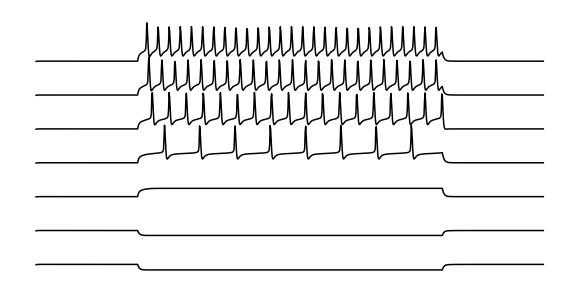

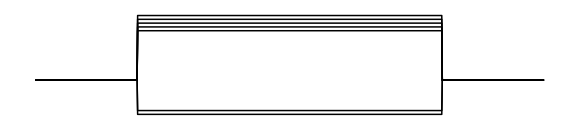

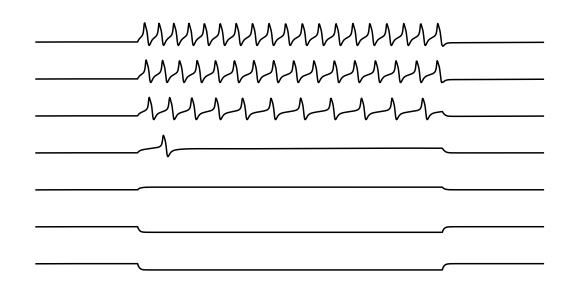

In [113]:
plt.figure(figsize=(10,5))
ax = plt.subplot(111)   
for i in range(25,30):
    plt.plot(90*(i-23)+state[::100,i],'k')
    print(current_input[i,::100].max())
for i in range(3,5):
    plt.plot(90*(i-3)+state[::100,i],'k')
    print(current_input[i,::100].min())
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)    
ax.spines['bottom'].set_visible(False)
plt.xticks([])
plt.yticks([])

plt.figure(figsize=(10,2))
ax = plt.subplot(111)   
for i in range(25,30):
    plt.plot(current_input[i,::100],'k')
for i in range(3,5):
    plt.plot(current_input.T[::100,i],'k')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)    
ax.spines['bottom'].set_visible(False)
plt.xticks([])
plt.yticks([])

plt.figure(figsize=(10,5))
ax = plt.subplot(111)   
for i in range(15,20):
    plt.plot(90*(i-13)+state[::100,32+i],'k')
    print(current_input[32+i,::100].max())
for i in range(3,5):
    plt.plot(90*(i-3)+state[::100,32+i],'k')
    print(current_input[32+i,::100].min())
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)    
ax.spines['bottom'].set_visible(False)
plt.xticks([])
plt.yticks([])

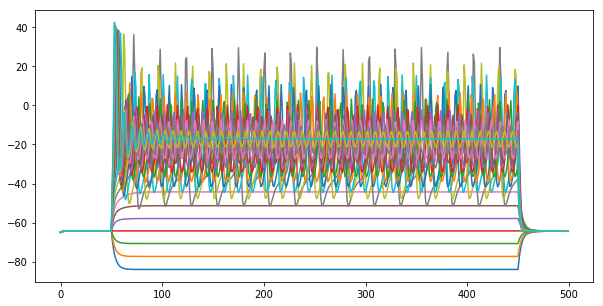

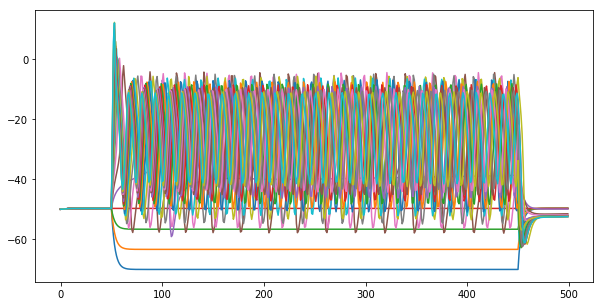

In [58]:


plt.figure(figsize=(10,5))
for i in range(20):
    plt.plot(state[::100,i])
    
plt.figure(figsize=(10,5))
for i in range(20):
    plt.plot(state[::100,20+i])

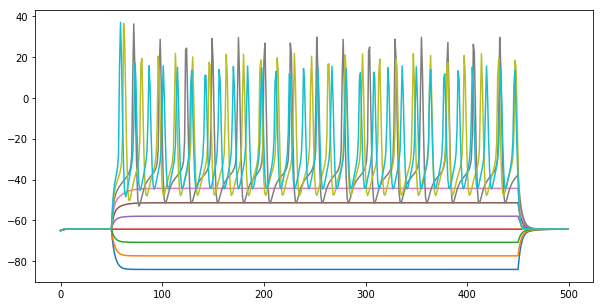

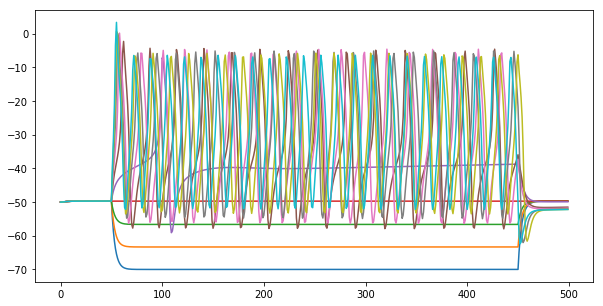

In [9]:
state=state[:,:-n_n]

plt.figure(figsize=(10,5))
for i in range(10):
    plt.plot(state[::100,i])
    
plt.figure(figsize=(10,5))
for i in range(10):
    plt.plot(state[::100,10+i])

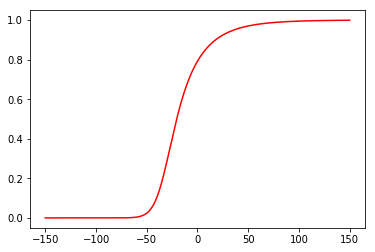

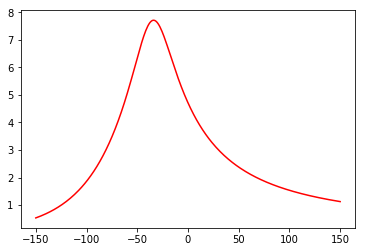

In [10]:
with tf.Session() as sess:
    stateK = sess.run(K_prop(np.linspace(-150,150,300)))
    #stateK_2 = sess.run(K_prop_2(np.linspace(-150,150,300)))
    plt.plot(np.linspace(-150,150,300),stateK[0],'r')
    #plt.plot(np.linspace(-150,150,300),stateK_2[0],'r.')
    plt.show()
    plt.plot(np.linspace(-150,150,300),stateK[1],'r')
    #plt.plot(np.linspace(-150,150,300),stateK_2[1],'r.')